In [1]:
import pandas as pd
import numpy as np
from time import time
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.neighbors import KNeighborsRegressor

In [2]:
df = pd.read_csv('data/wine_final.csv',index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24997 entries, 0 to 24996
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      24989 non-null  object 
 1   County       20809 non-null  object 
 2   Designation  17633 non-null  object 
 3   Points       24997 non-null  int64  
 4   Price        23373 non-null  float64
 5   Province     24989 non-null  object 
 6   Title        24997 non-null  object 
 7   Variety      24997 non-null  object 
 8   Winery       24997 non-null  object 
 9   Year         24997 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [4]:
df.isnull().sum()

Country           8
County         4188
Designation    7364
Points            0
Price          1624
Province          8
Title             0
Variety           0
Winery            0
Year              0
dtype: int64

In [5]:
df.dropna(subset=['Country'],inplace=True)
df.reset_index(drop=True,inplace=True)

In [6]:
# Impute mean(price) for the country if price is NaN
# If all prices for the country are NaN, impute with the mean(price) of a dataframe

def impute_numerical(categorical_column, numerical_column):
    frames = []
    for i in list(set(df[categorical_column])):
        df_category = df[df[categorical_column]== i]
        if len(df_category) > 1:    
            df_category[numerical_column].fillna(df_category[numerical_column].mean(),inplace = True)        
        else:
            df_category[numerical_column].fillna(df[numerical_column].mean(),inplace = True)
        frames.append(df_category)    
        final_df = pd.concat(frames)
    return final_df

In [7]:
impute_price  = impute_numerical('Country', 'Price')
df = impute_price
df.reset_index(drop=True,inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [8]:
# def impute_county(categorical_column1, categorical_column2):
#     cat_frames = []
#     for i in list(set(df[categorical_column1])):
#         df_category = df[df[categorical_column1]== i]
#         if len(df_category) > 1 and (df_category[categorical_column2].isna().sum() < len(df_category[categorical_column2])):    
#             df_category[categorical_column2].fillna(df_category[categorical_column2].mode()[0],inplace = True)        
#         else:
#             df_category[categorical_column2].fillna(' ',inplace = True)
#         cat_frames.append(df_category)    
#         cat_df = pd.concat(cat_frames)
#     return cat_df

In [9]:
# df = impute_county('Country', 'County')
# df.reset_index(drop=True,inplace=True)

In [10]:
# for county = NaN, the county feature for all the observations for that contry was NaN
# if county = NaN --> substitute county with country

df['County'].fillna(value=df['Country'],inplace=True)

In [11]:
df.isnull().sum()

Country           0
County            0
Designation    7360
Points            0
Price             0
Province          0
Title             0
Variety           0
Winery            0
Year              0
dtype: int64

In [12]:
df.nunique().sort_values(ascending=False)

Title          24571
Designation    11558
Winery          9033
County           937
Variety          449
Province         319
Price            263
Year              42
Country           37
Points            21
dtype: int64

In [13]:
enc = OneHotEncoder(drop='first',handle_unknown='error')
enc.fit(df['Country'].to_frame())


enc_df_country = pd.DataFrame(enc.transform(df[['Country']]).toarray(),columns=enc.categories_[0][1:])
df = df.join(enc_df_country)

In [14]:
enc = OneHotEncoder(drop='first',handle_unknown='error')
enc.fit(df['County'].to_frame())


enc_df_county = pd.DataFrame(enc.transform(df[['County']]).toarray(),columns=enc.categories_[0][1:])
df = df.join(enc_df_county,rsuffix='_County')

In [15]:
enc = OneHotEncoder(drop='first',handle_unknown='error')
enc.fit(df['Province'].to_frame())


enc_df_province = pd.DataFrame(enc.transform(df[['Province']]).toarray(),columns=enc.categories_[0][1:])
df = df.join(enc_df_province,rsuffix='_Province')

In [16]:
enc = OneHotEncoder(drop='first',handle_unknown='error')
enc.fit(df['Variety'].to_frame())


enc_df_variety = pd.DataFrame(enc.transform(df[['Variety']]).toarray(),columns=enc.categories_[0][1:])
df = df.join(enc_df_variety,rsuffix='_Variety')

In [17]:
enc = OneHotEncoder(drop='first',handle_unknown='error')
enc.fit(df['Winery'].to_frame())


enc_df_winery = pd.DataFrame(enc.transform(df[['Winery']]).toarray(),columns=enc.categories_[0][1:])
df = df.join(enc_df_winery,rsuffix='_winery')

In [18]:
X=df.drop(['Title','Points','Designation','Country','County','Province','Variety','Winery'],axis=1)

In [19]:
y=df['Points']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
mean_points = y_train.mean()
mean_points

88.50147566404883

In [22]:
def rmsle(actual, predictions):
    log_diff = np.log(predictions) - np.log(actual)
    return np.sqrt(np.mean(log_diff**2))

In [23]:
def rmse(actual, predictions):    
    return np.sqrt(np.mean((predictions - actual)**2))

## Base Model RMSE & RMSLE

In [24]:
rmsle(y_train, np.full(len(y_train), mean_points))

0.034287545605854744

In [25]:
rmse(y_train, np.full(len(y_train), mean_points))

3.033005923108891

## Random Forest Model

In [26]:
start=time()
RF = RandomForestRegressor(max_features='sqrt')
RF.fit(X_train,y_train)
yhat = RF.predict(X_test)
print('Finished Random Forest Model in:', time() - start, '\n')

Finished Random Forest Model in: 232.56189489364624 



In [27]:
print(f'RMSLE for Random Forest Model is {rmsle(yhat, y_test)}')
print(f'RMSE for Random Forest Model is {rmse(yhat, y_test)}')

RMSLE for Random Forest Model is 0.024539851798413285
RMSE for Random Forest Model is 2.161460412197547


### RF Feature Importance

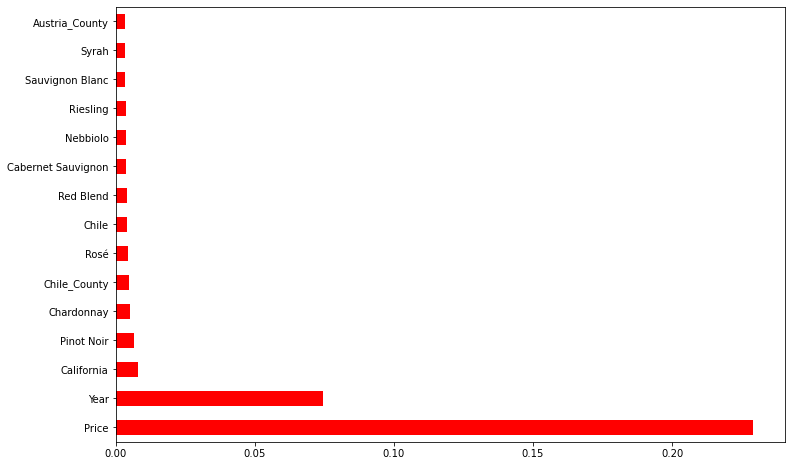

In [28]:
(pd.Series(RF.feature_importances_, index=X_train.columns)
   .nlargest(15)
   .plot(kind='barh',figsize=(12,8),color='red'))
plt.show()

In [29]:
#df.drop(['Title','Designation','Country','County','Province','Variety','Winery'],axis=1,inplace=True)

In [30]:
# df.to_csv('data/post_rf.csv')

## Ridge Model

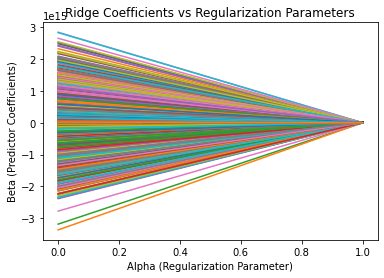

In [31]:
coef=[]
alphas = range(0,2)

for a in alphas:
  ridgereg=Ridge(alpha=a)
  ridgereg.fit(X_train,y_train)
  coef.append(ridgereg.coef_)

###Make plot of Beta as a function of Alpha
fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(alphas,coef)
ax.set_xlabel('Alpha (Regularization Parameter)')
ax.set_ylabel('Beta (Predictor Coefficients)')
ax.set_title('Ridge Coefficients vs Regularization Parameters')
ax.axis('tight')
plt.show()

In [32]:
start=time()
ridgereg=Ridge(alpha=a)
ridgereg.fit(X_train,y_train)
yhat = ridgereg.predict(X_test)
print('Finished Ridge Model in:', time() - start, '\n')

Finished Ridge Model in: 69.4651141166687 



In [33]:
print(f'RMSLE for Ridge Model is {rmsle(yhat, y_test)}')
print(f'RMSE for Ridge Model is {rmse(yhat, y_test)}')
print(f'The coefficient R^2 is {ridgereg.score(X_train, y_train)}')

RMSLE for Ridge Model is 0.02675542450729193
RMSE for Ridge Model is 2.366794190980722
The coefficient R^2 is 0.6885562597684147


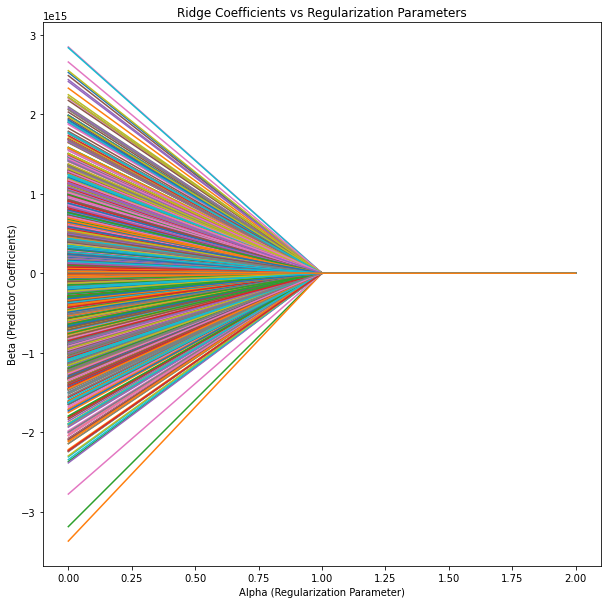

In [34]:
coef=[]
alphas = range(0,3)

for a in alphas:
  ridgereg=Ridge(alpha=a)
  ridgereg.fit(X_train,y_train)
  coef.append(ridgereg.coef_)

###Make plot of Beta as a function of Alpha
fig=plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.plot(alphas,coef)
ax.set_xlabel('Alpha (Regularization Parameter)')
ax.set_ylabel('Beta (Predictor Coefficients)')
ax.set_title('Ridge Coefficients vs Regularization Parameters')
ax.axis('tight')
plt.show()

## XGB Model

Squared Error
[0]	dtrain-rmse:61.66873	dtest-rmse:61.60504
[1]	dtrain-rmse:43.20826	dtest-rmse:43.15077
[2]	dtrain-rmse:30.29976	dtest-rmse:30.24632
[3]	dtrain-rmse:21.28277	dtest-rmse:21.23137
[4]	dtrain-rmse:14.99773	dtest-rmse:14.94802
[5]	dtrain-rmse:10.63420	dtest-rmse:10.59071
[6]	dtrain-rmse:7.62926	dtest-rmse:7.59152
[7]	dtrain-rmse:5.58998	dtest-rmse:5.55923
[8]	dtrain-rmse:4.24055	dtest-rmse:4.22328
[9]	dtrain-rmse:3.38525	dtest-rmse:3.37932
[10]	dtrain-rmse:2.87187	dtest-rmse:2.87804
[11]	dtrain-rmse:2.58108	dtest-rmse:2.59914
[12]	dtrain-rmse:2.41960	dtest-rmse:2.45059
[13]	dtrain-rmse:2.33277	dtest-rmse:2.37199
[14]	dtrain-rmse:2.28905	dtest-rmse:2.33425
[15]	dtrain-rmse:2.26432	dtest-rmse:2.31490
[16]	dtrain-rmse:2.24885	dtest-rmse:2.30413
[17]	dtrain-rmse:2.23923	dtest-rmse:2.29816
[18]	dtrain-rmse:2.23306	dtest-rmse:2.29447
[19]	dtrain-rmse:2.22715	dtest-rmse:2.29104
Finished Squared Error in: 22.537879943847656 

Squared Log Error
[0]	dtrain-rmsle:3.87242	dtest-rmsle:3

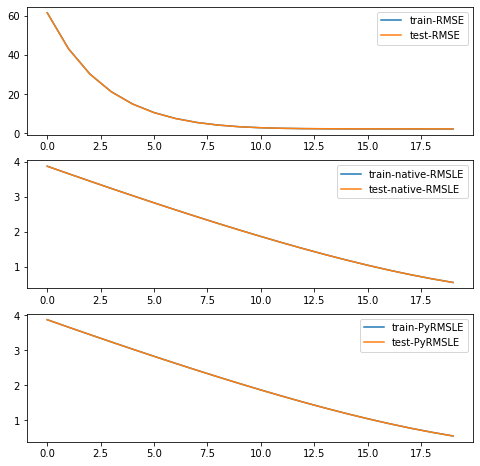

In [35]:
'''Demo for defining customized metric and objective.  Notice that for
simplicity reason weight is not used in following example. In this
script, we implement the Squared Log Error (SLE) objective and RMSLE metric as customized
functions, then compare it with native implementation in XGBoost.
See doc/tutorials/custom_metric_obj.rst for a step by step
walkthrough, with other details.
The `SLE` objective reduces impact of outliers in training dataset,
hence here we also compare its performance with standard squared
error.
'''
import numpy as np
import xgboost as xgb
from typing import Tuple, Dict, List
from time import time
import argparse
import matplotlib
from matplotlib import pyplot as plt

kSeed = 42

kBoostRound = 20

def native_rmse(dtrain: xgb.DMatrix,
                dtest: xgb.DMatrix) -> Dict[str, Dict[str, List[float]]]:
    '''Train using native implementation of Root Mean Squared Loss.'''
    print('Squared Error')
    squared_error = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'tree_method': 'hist',
        'seed': kSeed
    }
    start = time()
    results: Dict[str, Dict[str, List[float]]] = {}
    xgb.train(squared_error,
              dtrain=dtrain,
              num_boost_round=kBoostRound,
              evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
              evals_result=results)
    print('Finished Squared Error in:', time() - start, '\n')
    return results


def native_rmsle(dtrain: xgb.DMatrix,
                 dtest: xgb.DMatrix) -> Dict[str, Dict[str, List[float]]]:
    '''Train using native implementation of Squared Log Error.'''
    print('Squared Log Error')
    results: Dict[str, Dict[str, List[float]]] = {}
    squared_log_error = {
        'objective': 'reg:squaredlogerror',
        'eval_metric': 'rmsle',
        'tree_method': 'hist',
        'seed': kSeed
    }
    start = time()
    xgb.train(squared_log_error,
              dtrain=dtrain,
              num_boost_round=kBoostRound,
              evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
              evals_result=results)
    print('Finished Squared Log Error in:', time() - start)
    return results


def py_rmsle(dtrain: xgb.DMatrix, dtest: xgb.DMatrix) -> Dict:
    '''Train using Python implementation of Squared Log Error.'''
    def gradient(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
        '''Compute the gradient squared log error.'''
        y = dtrain.get_label()
        return (np.log1p(predt) - np.log1p(y)) / (predt + 1)

    def hessian(predt: np.ndarray, dtrain: xgb.DMatrix) -> np.ndarray:
        '''Compute the hessian for squared log error.'''
        y = dtrain.get_label()
        return ((-np.log1p(predt) + np.log1p(y) + 1) /
                np.power(predt + 1, 2))

    def squared_log(predt: np.ndarray,
                    dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:
        '''Squared Log Error objective. A simplified version for RMSLE used as
        objective function.
        :math:`\frac{1}{2}[log(pred + 1) - log(label + 1)]^2`
        '''
        predt[predt < -1] = -1 + 1e-6
        grad = gradient(predt, dtrain)
        hess = hessian(predt, dtrain)
        return grad, hess

    def rmsle(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
        ''' Root mean squared log error metric.
        :math:`\sqrt{\frac{1}{N}[log(pred + 1) - log(label + 1)]^2}`
        '''
        y = dtrain.get_label()
        predt[predt < -1] = -1 + 1e-6
        elements = np.power(np.log1p(y) - np.log1p(predt), 2)
        return 'PyRMSLE', float(np.sqrt(np.sum(elements) / len(y)))

    results: Dict[str, Dict[str, List[float]]] = {}
    xgb.train({'tree_method': 'hist', 'seed': kSeed,
               'disable_default_eval_metric': 1},
              dtrain=dtrain,
              num_boost_round=kBoostRound,
              obj=squared_log,
              feval=rmsle,
              evals=[(dtrain, 'dtrain'), (dtest, 'dtest')],
              evals_result=results)

    return results


def plot_history(rmse_evals, rmsle_evals, py_rmsle_evals):
    fig, axs = plt.subplots(3, 1,figsize=(8,8))
    ax0: matplotlib.axes.Axes = axs[0]
    ax1: matplotlib.axes.Axes = axs[1]
    ax2: matplotlib.axes.Axes = axs[2]

    x = np.arange(0, kBoostRound, 1)

    ax0.plot(x, rmse_evals['dtrain']['rmse'], label='train-RMSE')
    ax0.plot(x, rmse_evals['dtest']['rmse'], label='test-RMSE')
    ax0.legend()

    ax1.plot(x, rmsle_evals['dtrain']['rmsle'], label='train-native-RMSLE')
    ax1.plot(x, rmsle_evals['dtest']['rmsle'], label='test-native-RMSLE')
    ax1.legend()

    ax2.plot(x, py_rmsle_evals['dtrain']['PyRMSLE'], label='train-PyRMSLE')
    ax2.plot(x, py_rmsle_evals['dtest']['PyRMSLE'], label='test-PyRMSLE')
    ax2.legend()

    plt.show()
    plt.close()


def main(args):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
#     dtrain, dtest = generate_data()
    rmse_evals = native_rmse(dtrain, dtest)
    rmsle_evals = native_rmsle(dtrain, dtest)
    py_rmsle_evals = py_rmsle(dtrain, dtest)

    if args.plot != 0:
        plot_history(rmse_evals, rmsle_evals, py_rmsle_evals)


if __name__ == '__main__':
    parser = argparse.ArgumentParser(
        description='Arguments for custom RMSLE objective function demo.')
    parser.add_argument(
        '--plot',
        type=int,
        default=1,
        help='Set to 0 to disable plotting the evaluation history.')
    args, unknown = parser.parse_known_args()
    main(args)

## KNN Model

In [36]:
neigh = KNeighborsRegressor(n_neighbors=2)
start=time()
neigh.fit(X_train,y_train)
yhat=neigh.predict(X_test)

print('Finished KNN Model in:', time() - start, '\n')
print(f'RMSLE for KNN is {rmsle(yhat, y_test)}')
print(f'RMSE for KNN is {rmse(yhat, y_test)}')

print(f'The coefficient R^2 for KNN is {neigh.score(X_train, y_train)}')

Finished KNN Model in: 99.60198497772217 

RMSLE for KNN is 0.029647575597319134
RMSE for KNN is 2.6169236358224692
The coefficient R^2 for KNN is 0.7581494236492387
